<img src="../Pnuemonia_Classifier/KyleDevLogo.jpg" alt="Kyles Logo" style="width: 1000px; border-radius: 2%; margin: auto; display: block;" />

# **Alzheimers Demented Classification**
By: Kyle Hostetter

## Data Information

This was a dataset that was gathered from Kaggle.com that contains 6,400 images of 4 major classes of alzheimers. The classes are non, very mild, mild, and moderate demented. The goal is to create a CNN model that will classify each of these stages with the highest accuracy possible!

**Data**
* Non Demented
* Very Mild Demented
* Mild Demented
* Moderate Demented

## Import Libraries

In [1]:
# Import Base Libraries
import os 
import numpy as np
import pandas as pd
from glob import glob 
import matplotlib.pyplot as plt

# Import Deep Learning Libraries
import tensorflow as tf
from keras import layers
from tensorflow import keras

# Set Constant Variables
DATA_DIR = 'Dataset/'
EPOCHS = 25
BATCH_SIZE = 64
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# Change TensorFlow settings
os.environ['TF_SPP_MIN_LOG_LEVEL'] = '2'                 # Change the logging output level to 2
physical_cpus = tf.config.list_physical_devices('CPU')   # List all CPU devices       
physical_gpus = tf.config.list_physical_devices('GPU')   # List all GPU devices

# Print out TensorFlow Version
print(f'''Tensorflow Version: {tf.__version__}''')
print(f'''CPU Devices: ''',physical_cpus)
print(f'''GPU Devices: ''',physical_gpus)

Tensorflow Version: 2.16.1
CPU Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
GPU Devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## EDA

In [2]:
# All Class Names 
class_names = ['Non Demented', 'Very Mild Demented',
               'Mild Demented', 'Moderate Demented']

# Non Demented Images
non_images = glob(DATA_DIR + 'Non_Demented/*.jpg')

# Very Mild Demented Images
very_mild_images = glob(DATA_DIR + '/Very_Mild_Demented/*.jpg')

# Mild Demented Images
mild_images = glob(DATA_DIR + '/Mild_Demented/*.jpg')

# Moderate Demented Images
moderate_images = glob(DATA_DIR + '/Moderate_Demented/*.jpg')

# Input Data
data = {'Class Name':class_names,
        'Amount of Images':[len(non_images),len(very_mild_images),
                            len(mild_images),len(moderate_images)]}

# Put data into dataframe
files_df = pd.DataFrame.from_dict(data)

# Show data in DataFrame format
display(files_df)

,Class Name,Amount of Images
0,Non Demented,3200
1,Very Mild Demented,2240
2,Mild Demented,896
3,Moderate Demented,64


### Obeservations-
* We can see that there is a small amount of files for moderate demented diagnosises. We may have to implement some sampling for analysis, but otherwise we have plenty of samples for training

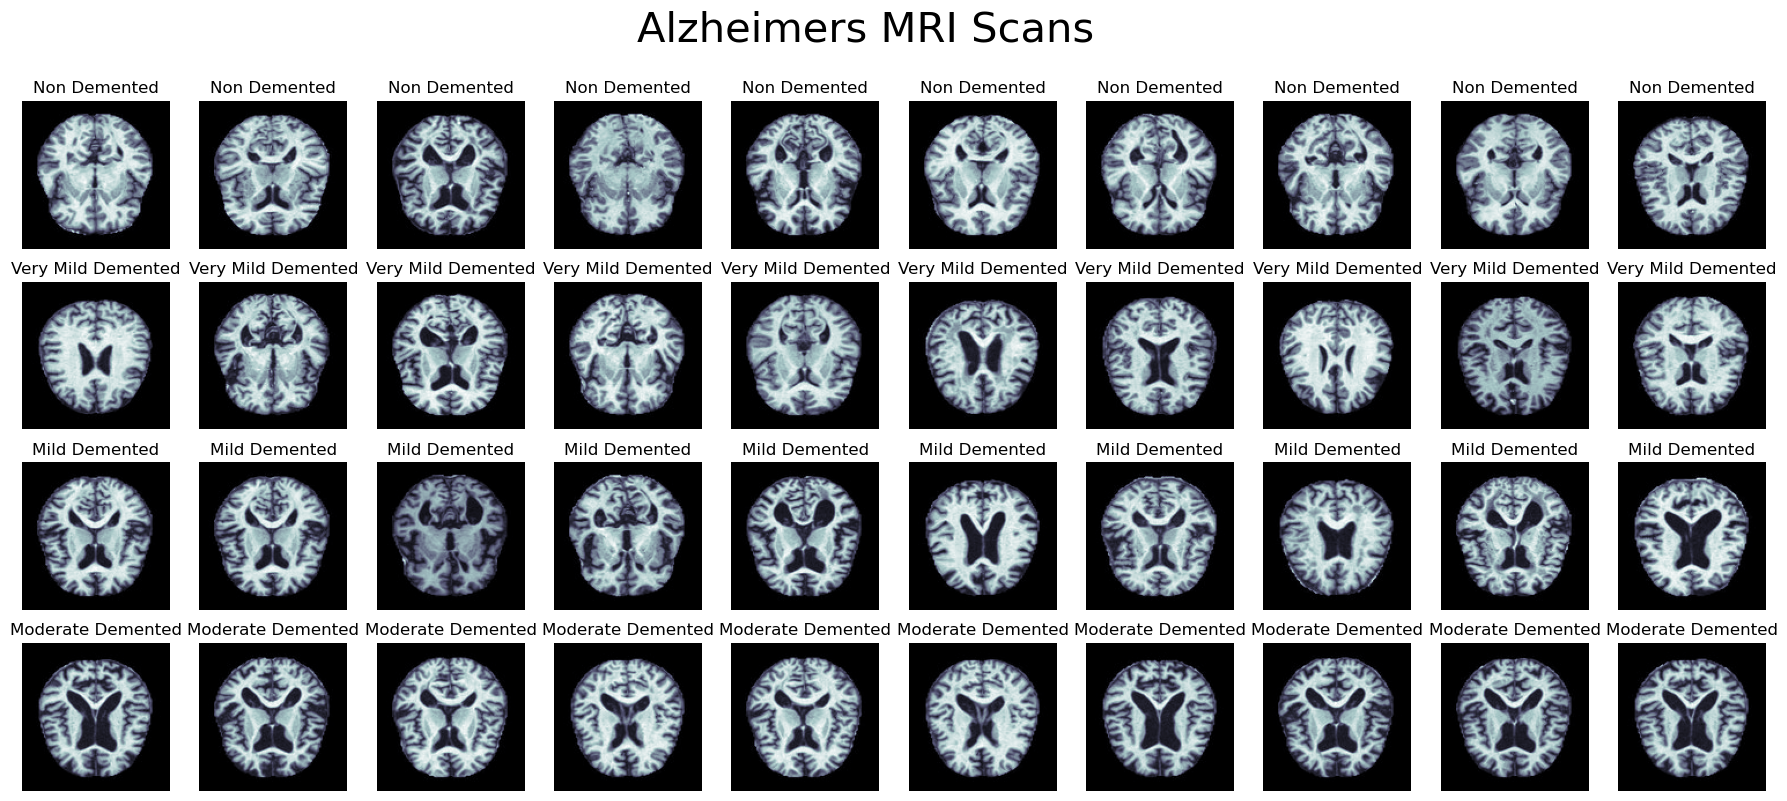

In [58]:
# List of image arrays
image_folders = [non_images,very_mild_images,mild_images,moderate_images]

# Create MRI Image function
def showMRIimages(image_folders, class_names, columns, colorMap, title):
    '''
    Title: Show MRI Images
    Description: This will create and show a plot samples of MRI scans 
    for patients with increasing levels of alzheimers.
    images_folders: List of image arrays.
    class_names: List of class names that correlate indexes with image_folders.
    columns: Number of columns in chart.
    colorMap: Matplotlib Continous Color Map.
    title: Title of chart
    '''
    # Set columns to amount of folders
    rows = len(image_folders)

    # Set Figure Size
    plt.figure(figsize=(columns*2.25,9))
    plt.suptitle(title, fontsize=30)

    # Create Counters
    t=0
    j=1

    # For each Image Folder
    for image_folder in image_folders:

            # Create show 4 images
            for i in range(columns):
                plt.subplot(rows, columns,j)
                plt.imshow(np.asarray(plt.imread(image_folder[i])), cmap=colorMap)
                plt.title(f'''{class_names[t]}''')
                plt.axis('off')
                j=j+1
            t=t+1
    
    # Show Images
    plt.show()

# Show MRI Images
showMRIimages(image_folders=image_folders,
              class_names=class_names,
              columns=10,
              colorMap='bone',
              title='Alzheimers MRI Scans')

### Observations-
* One thing to notice when looking throuh the MRI images above, is that the brain images that have an enlarged ventricles and less dense grey matter so difference between normal and alzheimers effected brains.
* With the filter above, you can see that there is slightly less grey matter, and some brina images, have alot larger ventricles than others.

## Create Training & Testing DataFrames

In [4]:
# Create Training and testing DataFrames
train_df, test_df = tf.keras.preprocessing.image_dataset_from_directory(directory=DATA_DIR,                      # Directory containing data files
                                                                        color_mode='grayscale',                  # There is no RGB in images so we put gray scale
                                                                        label_mode='int',                        # We will be using a Sparse Catgorical Entropy loss funciton later
                                                                        batch_size=BATCH_SIZE,                   # Define batch size for tensor dataframe info
                                                                        image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),   # Set Height & Width of Images
                                                                        validation_split=.2,                     # Split 80% to train_df & 20% to test_df
                                                                        subset='both',                           # return both a train_df and testing_df
                                                                        shuffle=True,                            # Shuffle Values 
                                                                        seed=0)                                  # Set seed value for shuffled dataframes

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Using 1280 files for validation.


2024-05-09 18:11:48.224061: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-09 18:11:48.224084: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-09 18:11:48.224090: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-09 18:11:48.224131: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-09 18:11:48.224145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Quick Note
* By using the image_dataset_from_directory function there is easy creation of training and testing dataframes that are tensor dataframes. 

## Deep Learning CNN Network

In [39]:
# Input Variables for Deep Learning Model
EPOCHS = 25       # Number of training and testing cycles
MATRIX = (4,4)    # Input matric that uses 2x2 pixels.
BATCH_SIZE = 64   # Sizes of Batches  

# Build Convolution Neural Network
model = keras.Sequential(name='Alzheimers_CNN', layers=
    [
        keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1), name='Input_Layer'),
        layers.Rescaling(1./255, name='Res_Layer1'),
        
        layers.Conv2D(32, MATRIX, padding='same', activation='relu', name='Conv_Layer1'),
        layers.MaxPooling2D(name='Max_Pooling1'),

        layers.Conv2D(64, MATRIX, padding='same', activation='relu', name='Conv_Layer2'),
        layers.MaxPooling2D(name='Max_Pooling2'),
        
        layers.Flatten(name='Flatten_Layer'),
        layers.Dense(32, activation='relu', name='Dense_layer'),
        layers.Dense(4, activation='softmax', name='Final_Output')
    ]
)

# Print Out Model Architecture
print(model.summary())

# Run & Compile Deep Learning Model
model.compile(optimizer='adam',                         # Use the Adam optimizer
              loss='sparse_categorical_crossentropy',   # Use sparse crossentropy since there are more than 2 classes
              metrics=['accuracy'])                     # Optimize Accuracy of model

# Create a Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',   # Metric to watch during training 
                                            patience=2)           # Continue training 2 epocks past a decrease in the monitor feature

# Train model
history=model.fit(train_df,                  # Data to train on       
                  validation_data=test_df,   # Validation Data
                  epochs=EPOCHS,             # Number of Epochs 
                  batch_size=BATCH_SIZE,     # Number of samples to train in SGD at a time
                  callbacks=[callback])      # Stop early if there is no increase in model metrics

# Evaluate Model
test_loss, test_score = model.evaluate(test_df,                 # What data to evaluate model on          
                                       batch_size=BATCH_SIZE)   # Number of samples to train in SGD at a time

# Delete Old Model & Save New Keras Model
os.remove('Alzheimers_CNN_Model.keras')
# model.save("Alzheimers_CNN_Model.h5")
model.save("Alzheimers_CNN_Model.keras")

# Print out Final results
print(f'''\n

        Final Model Results
----------------------------------
Accuracy: {round(test_score * 100,1)}%
Loss: {test_loss}
''')

Model: "Alzheimers_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Res_Layer1 (Rescaling)          │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Layer1 (Conv2D)            │ (None, 128, 128, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling1 (MaxPooling2D)     │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Layer2 (Conv2D)            │ (None, 64, 64, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Max_Pooling2 (MaxPooling2D)     │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_layer (Dense)             │ (None, 32)             │     2,097,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Final_Output (Dense)            │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,130,692 (8.13 MB)

 Trainable params: 2,130,692 (8.13 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.4635 - loss: 1.0554 - val_accuracy: 0.5609 - val_loss: 0.9521
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5703 - loss: 0.9045 - val_accuracy: 0.6477 - val_loss: 0.7998
Epoch 3/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6649 - loss: 0.7396 - val_accuracy: 0.7742 - val_loss: 0.5764
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8137 - loss: 0.4629 - val_accuracy: 0.8266 - val_loss: 0.4625
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9103 - loss: 0.2589 - val_accuracy: 0.8891 - val_loss: 0.2800
Epoch 6/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9539 - loss: 0.1456 - val_accuracy: 0.9234 - val_loss: 0.2080
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9851 - loss: 0.0664 - val_accuracy: 0.9633 - val_loss: 0.1249
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.9924 - loss: 0.0353 - val_accuracy: 0.970

### Observations-
* Here we can see a pretty good performance of our model! Over 95%! 
* Another thing to note is that, creating a larger model than needed just increases training time and complexity. Sometimes complexity is needed in more difficult problems, but with just 128x128 grayscale pixels, we don't neeed to worry about that right now!

## Final Results

In [40]:
def predictImage(model,image):
    '''
    Title: Predict Image
    Description: This function will take in a np.array image and return the 
    class name of the image and the probability with that prediction.
    model: This is the pre-trained CNN model.
    image: This is the numpy array of the image that you want to predict.
    '''

    # Class Name Labels
    labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

    # Expand image into readalbe image array
    fixed_image = np.expand_dims(image,axis=0)

    # Apply prediciton model
    pred_image = model.predict(fixed_image)

    # Index of highest probability image
    index_max = np.argmax(pred_image)

    # Attach Class Label
    pred = labels[index_max]
    proba = round(pred_image[0][index_max] * 100,2)

    # Return Highest probable label
    return proba, pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

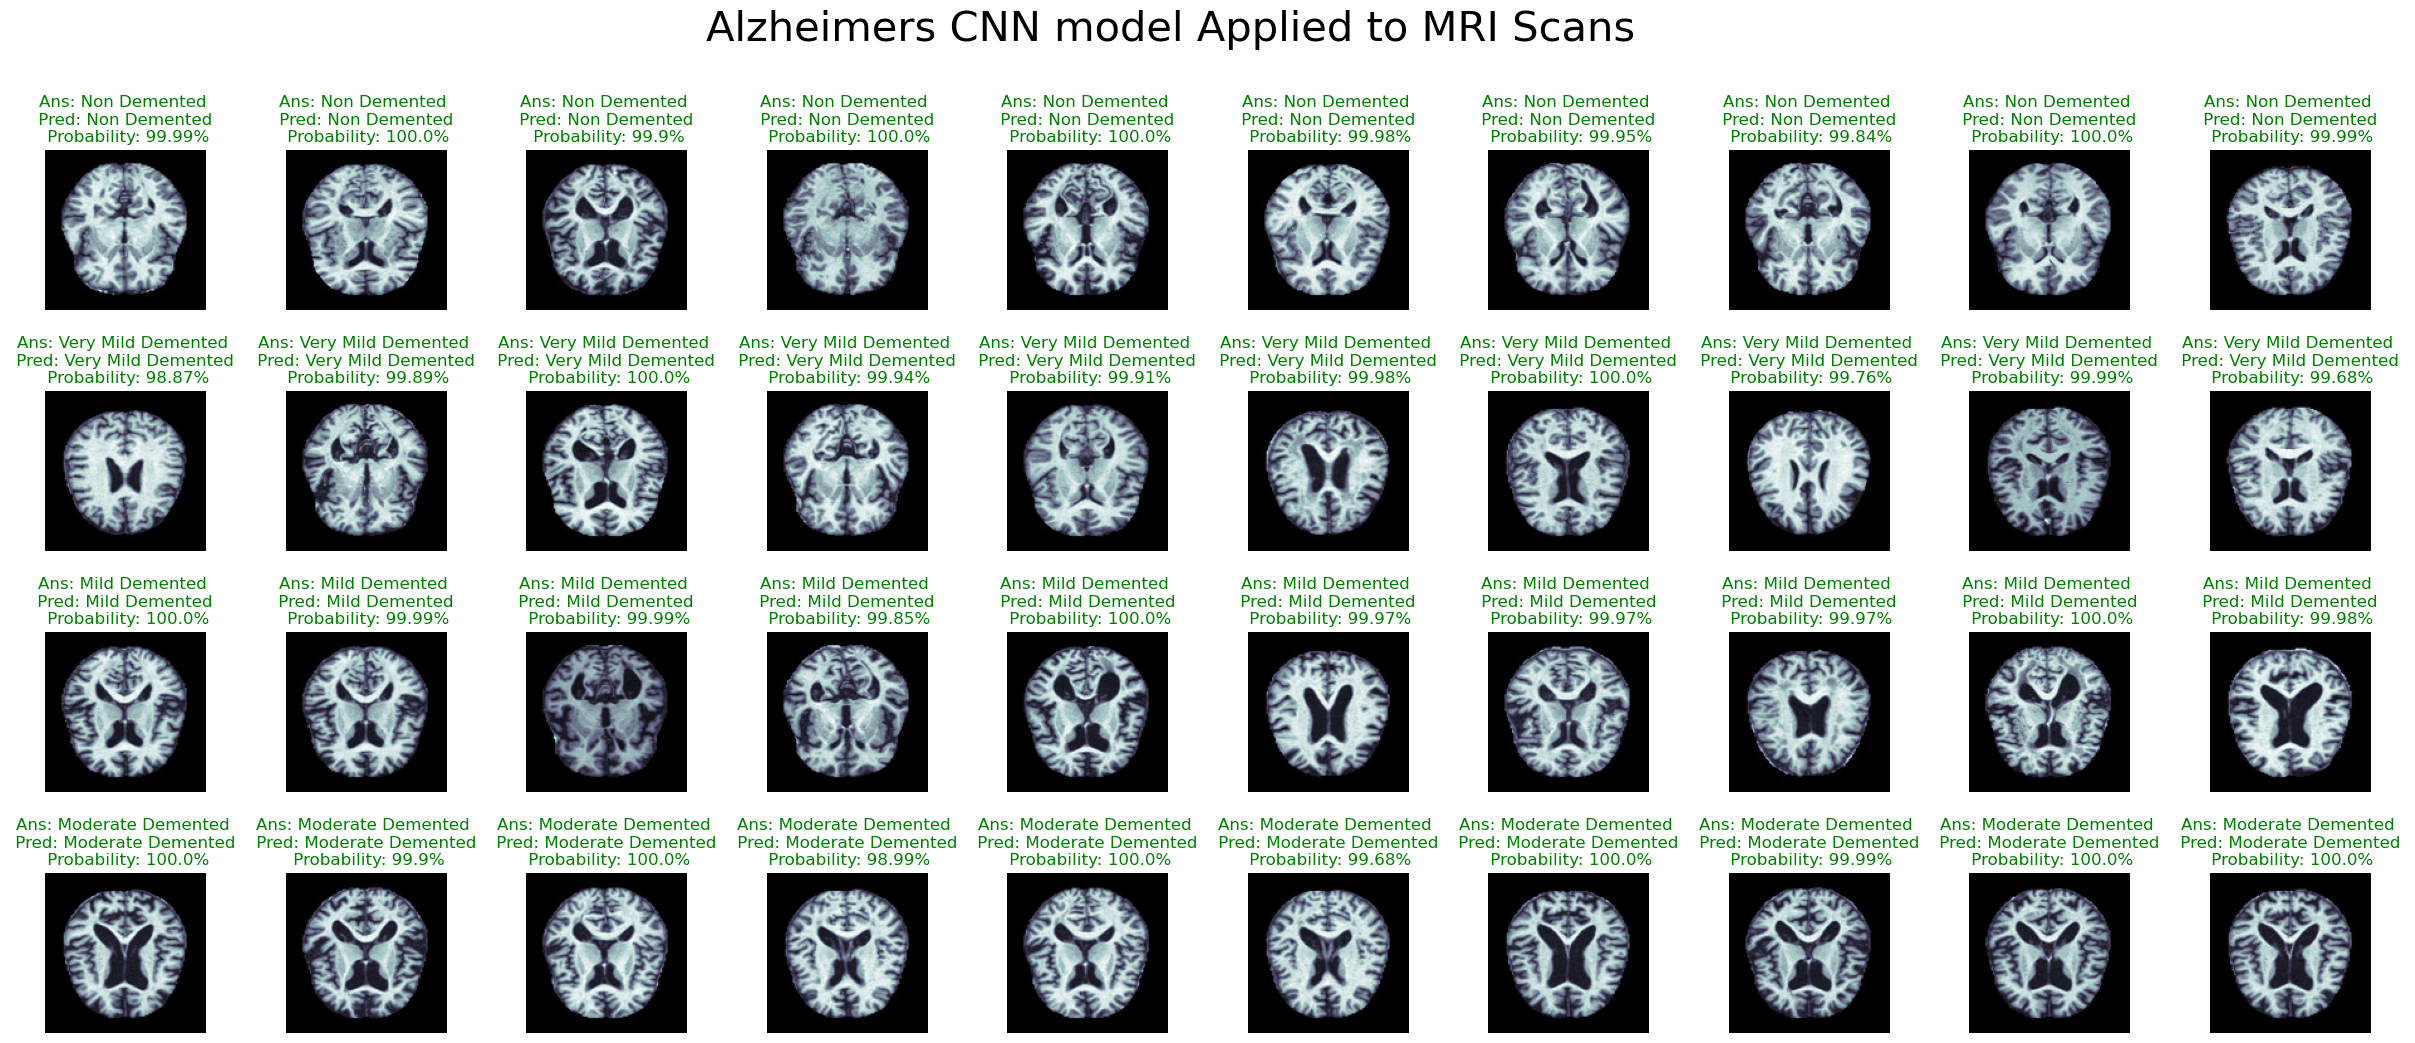

In [55]:
# Create MRI Image function
def predictShowMRIimages(image_folders, class_names, columns, colorMap, title, model):
    '''
    Title: Predict & Show MRI Images
    Description: This will create and show a plot samples of MRI scans 
    for patients with increasing levels of alzheimers.
    images_folders: List of image arrays.
    class_names: List of class names that correlate indexes with image_folders.
    columns: Number of columns in chart.
    colorMap: Matplotlib Continous Color Map.
    title: Title of chart.
    model: This is the pre-trained CNN model.
    '''

    # Set columns to amount of folders
    rows = len(image_folders)

    # Set Figure Size
    plt.figure(figsize=(columns*3,12))

    # Figure Title and Font Size
    plt.suptitle(title, fontsize=30)

    # Create Counters
    t=0
    j=1

    # For each Image Folder
    for image_folder in image_folders:

            # Create show 4 images
            for i in range(columns):
                
                # Create np array of image
                np_image = np.asarray(plt.imread(image_folder[i]))

                # Output probability and predicted value
                proba, pred = predictImage(model=model, image=np_image)

                # Check for a match
                if pred == class_names[t]:
                    pred_color = 'green'
                else:
                    pred_color = 'red'

                # Create subplot
                plt.subplot(rows, columns,j)
                plt.subplots_adjust(wspace=0.5)
                plt.imshow(np.asarray(plt.imread(image_folder[i])), cmap=colorMap)
                plt.title(f'''Ans: {class_names[t]} \n Pred: {pred} \n Probability: {proba}%''', color=pred_color)
                plt.axis('off')
                j=j+1
            t=t+1
    
    # Show Images
    plt.show()

# Show MRI Images
predictShowMRIimages(image_folders=image_folders,                         # List of image folders
                     class_names=class_names,                             # List of class names
                     columns=10,                                           # Number of columns
                     colorMap='bone',                                     # Image Color filter
                     title='Alzheimers CNN model Applied to MRI Scans',   # Title of Figure
                     model=model)                                         # Pre-Trained CNN Model